In [1]:
# Modify the file A00_setup.  Note the working directory is changed
import os
os.chdir(os.getcwd().rsplit(os.path.sep + 'code')[0] + os.path.sep + 'code')
from importlib.machinery import SourceFileLoader
setup = SourceFileLoader("setup", "./A_target_count_encoding/A00_setup.py").load_module()
os.getcwd()

'/Users/valeriecarey/Documents/projects/2023_10_blog_gnn_sba/code'

# XGBoost with Threshold NA encoding of all NAICS groups
Encode only the base NAICS, industry, industry group, sector, subsector, etc.

*This script takes about 5 minutes on my MacBook Air*

In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
import warnings
import matplotlib.pyplot as plt
import pickle, importlib

In [3]:
from pathlib import Path

In [4]:
import sklearn as sk
from sklearn.model_selection import RandomizedSearchCV
from sklearn.inspection import permutation_importance, partial_dependence
from scikitplot.metrics import plot_lift_curve

In [5]:
from sba_gnn.sba_gnn import sg_plot, sg_thresh_encoder
from sba_gnn.sba_gnn.sg_thresh_encoder import TargetThreshEncoder

## Import Processed Dataset

In [6]:
sba_loans = pd.read_parquet(Path(setup.parent_path).joinpath('01_DATA_transformed.parquet')) 

In [7]:
train_df = sba_loans[sba_loans['dset'] == 'train']

In [8]:
# NAICS features
naics_features = ['NAICS', 'NAICS_5', 'NAICS_4', 'NAICS_3', 'NAICS_sector']
#naics_features = ['NAICS', 'NAICS_sector']

## Do the Encoding
Use the TargetCountEncoder to transform the NAICS feature to two columns per level of the NAICS hieararchy

In [52]:
importlib.reload(sg_thresh_encoder)
from sba_gnn.sba_gnn import sg_plot, sg_thresh_encoder
from sba_gnn.sba_gnn.sg_thresh_encoder import TargetThreshEncoder

In [53]:
# Create encoders
enc_dict = {f:TargetThreshEncoder(threshold = 1000) for f in naics_features}

In [54]:
# fit encoders
[enc_dict[f].fit(train_df[f], train_df['target']) for f in naics_features]

[None, None, None, None, None]

In [55]:
with open(Path(setup.temp_path).joinpath('A20_DATA_encoder.pkl'), 'wb') as fout:
    pickle.dump(enc_dict, fout)

In [56]:
# Transform the data
enc_val = pd.concat([enc_dict[f].transform(sba_loans[f]) for f in naics_features],
                    axis=1)
enc_val.columns = ['tt_' + f for f in enc_val.columns]

In [14]:
enc_val.head(3)

,tt_NAICS,tt_NAICS_5,tt_NAICS_4,tt_NAICS_3,tt_NAICS_sector
index,,,,,
0,0.229316,0.229316,0.188969,0.195057,0.223429
1,0.141762,0.141762,0.141762,0.240226,0.218456
2,0.040818,0.040818,0.040818,0.089955,0.100917


In [15]:
enc_val.isna().sum()

tt_NAICS           301774
tt_NAICS_5         260490
tt_NAICS_4         132005
tt_NAICS_3          22973
tt_NAICS_sector      2952
dtype: int64

In [16]:
# Save the values
pd.concat([sba_loans[['LoanNr_ChkDgt', 'dset', 'dset_naics_holdout', 'NAICS']] \
               .drop(columns=['count', 'response'], errors='ignore'), enc_val], axis = 1) \
    .to_parquet(Path(setup.temp_path).joinpath('A20_DATA_encodings.parquet'))

In [17]:
sba_loans = pd.concat([sba_loans.drop(columns=enc_val.columns, errors='ignore'), enc_val], 
                      axis=1)
print(sba_loans.shape)

(688081, 63)


In [18]:
sba_loans[['target'] + list(enc_val.columns)].corr()

,target,tt_NAICS,tt_NAICS_5,tt_NAICS_4,tt_NAICS_3,tt_NAICS_sector
target,1.000000,0.226425,0.220175,0.204470,0.180446,0.106663
tt_NAICS,0.226425,1.000000,0.988576,0.924027,0.803705,0.556591
tt_NAICS_5,0.220175,0.988576,1.000000,0.938196,0.810847,0.563656
tt_NAICS_4,0.204470,0.924027,0.938196,1.000000,0.884161,0.571647
tt_NAICS_3,0.180446,0.803705,0.810847,0.884161,1.000000,0.581905
tt_NAICS_sector,0.106663,0.556591,0.563656,0.571647,0.581905,1.000000


In [19]:
train_df = sba_loans[sba_loans['dset'] == 'train']
test_df = sba_loans[sba_loans['dset'] == 'test']
val_df = sba_loans[sba_loans['dset'] == 'val']

#### Set the predictor features. 

In [20]:
predictor_features = setup.predictor_features + list(enc_val.columns)
print(predictor_features)

['NoEmp', 'CreateJob', 'LowDoc', 'DisbursementGross', 'new_business', 'urban_flag', 'franchise_flag', 'tt_NAICS', 'tt_NAICS_5', 'tt_NAICS_4', 'tt_NAICS_3', 'tt_NAICS_sector']


In [21]:
with open(Path(setup.temp_path).joinpath('A20_DATA_features_predict.pkl'), 'wb') as fout:
    pickle.dump(predictor_features, fout)

## Model Fit

In [22]:
best_params_df = pd.read_csv(Path(setup.parent_path).joinpath('03_REPORT_fit_parameter_selected.csv'))
best_params = best_params_df.to_dict(orient='records')[0]
best_params

{'subsample': 0.8,
 'scale_pos_weight': 1.0,
 'reg_lambda': 0.01,
 'reg_alpha': 0.001,
 'min_child_weight': 50,
 'max_depth': 8,
 'learning_rate': 0.1,
 'gamma': 2}

##### Fit using pre-determined parameters

In [23]:
xgb_params = dict(best_params, 
                   **{'objective':"binary:logistic", 'n_estimators':setup.xgb_n_estimators})

In [24]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic",
                             n_estimators =  setup.xgb_n_estimators)

In [25]:
xgb_model = xgb_model.set_params(**xgb_params)

In [26]:
xgb_model.fit(train_df[predictor_features], train_df['target'],
              eval_set = [(train_df[predictor_features], train_df['target']),
                         (val_df[predictor_features], val_df['target'])])

[0]	validation_0-logloss:0.50089	validation_1-logloss:0.50442
[1]	validation_0-logloss:0.49376	validation_1-logloss:0.49744
[2]	validation_0-logloss:0.48782	validation_1-logloss:0.49157
[3]	validation_0-logloss:0.48269	validation_1-logloss:0.48657
[4]	validation_0-logloss:0.47830	validation_1-logloss:0.48233
[5]	validation_0-logloss:0.47461	validation_1-logloss:0.47879
[6]	validation_0-logloss:0.47128	validation_1-logloss:0.47552
[7]	validation_0-logloss:0.46848	validation_1-logloss:0.47285
[8]	validation_0-logloss:0.46613	validation_1-logloss:0.47060
[9]	validation_0-logloss:0.46393	validation_1-logloss:0.46845
[10]	validation_0-logloss:0.46209	validation_1-logloss:0.46671
[11]	validation_0-logloss:0.46044	validation_1-logloss:0.46516
[12]	validation_0-logloss:0.45896	validation_1-logloss:0.46376
[13]	validation_0-logloss:0.45769	validation_1-logloss:0.46257
[14]	validation_0-logloss:0.45667	validation_1-logloss:0.46167
[15]	validation_0-logloss:0.45574	validation_1-logloss:0.46082
[1

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=2, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=50, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=30, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [27]:
train_df['target'].value_counts()

target
0    346866
1     89254
Name: count, dtype: int64

##### Save the model

In [28]:
xgb_model.save_model(Path(setup.temp_path).joinpath('A20_MODEL_xgboost.json'))

In [29]:
with open(Path(setup.temp_path).joinpath('A20_MODEL_xgboost.pkl'), 'wb') as po:
    pickle.dump(xgb_model, po)

## Probability Predictions

In [30]:
pred_df = pd.concat([sba_loans[['LoanNr_ChkDgt', 'dset', 'target', 'dset_naics_holdout']].reset_index(),
                     pd.DataFrame({'predict_prob':
                                   xgb_model.predict_proba(sba_loans[predictor_features])[:,1]})],
                    axis=1) \
    .set_index('index')

In [31]:
pred_df.groupby('target')['predict_prob'].agg(['mean', 'std', 'min', 'max', 'median'])

,mean,std,min,max,median
target,,,,,
0,0.184716,0.113605,0.016708,0.655272,0.173068
1,0.282578,0.107608,0.018294,0.697109,0.287950


## Decision Threshold
Max f1, on training data

In [32]:
pred_train_df = pred_df[pred_df['dset'] == 'train']

In [33]:
thresh_tune_data = sg_plot.get_f1_frame(pred_train_df['target'], 
                                        pred_train_df['predict_prob'])

In [34]:
thresh_tune_data.to_csv(Path(setup.temp_path).joinpath('A20_REPORT_thresh_tune.csv'), index=False)

In [35]:
thresh_head = thresh_tune_data.sort_values('f1', ascending=False).head(2)
best_thresh = thresh_head['thresh'].iloc[0]
print(best_thresh)
thresh_head

0.24


,thresh,f1
12,0.24,0.453619
11,0.22,0.452708


##### Apply decision threshold
All datasets

In [36]:
pred_df['predict_bin'] = np.where(pred_df['predict_prob'] >= best_thresh, 1, 0)

In [37]:
pred_df['predict_bin'].value_counts()

predict_bin
0    402866
1    285215
Name: count, dtype: int64

In [38]:
pred_df.to_parquet(Path(setup.temp_path).joinpath('A20_DATA_combined_predictions.parquet'))

## Metrics

In [39]:
metrics_dset_df = pred_df.groupby('dset') \
    .apply(lambda x: sg_plot.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
    .reset_index()
metrics_test_df = pred_df[pred_df['dset'] == 'test'] \
    .groupby(['dset', 'dset_naics_holdout']) \
    .apply(lambda x: sg_plot.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
    .reset_index()
metrics_df = pd.concat([metrics_dset_df, metrics_test_df])
metrics_df.to_csv(Path(setup.temp_path).joinpath('A20_REPORT_metrics.csv'), index=True)
metrics_df

,dset,accuracy_score,f1_score,precision_score,recall_score,average_precision_score,roc_auc_score,dset_naics_holdout
0,test,0.669857,0.444019,0.331272,0.673109,0.377020,0.734691,NaN
1,train,0.658936,0.453619,0.337441,0.691801,0.390766,0.733896,NaN
2,val,0.655638,0.450294,0.336645,0.679783,0.384746,0.726803,NaN
0,test,0.655973,0.450795,0.335597,0.686417,0.383927,0.728898,0.0
1,test,0.689802,0.432871,0.324116,0.651468,0.366645,0.741540,1.0


thresh = 50 0.38797 / 0.365664 YES YES YES.  Thresh 200 0.387319 / 0.366205.  Thresh 1000 0.383927 / 0.366645

## Lift
Test data

In [40]:
pred_test_df = pred_df[pred_df['dset'] == 'test']

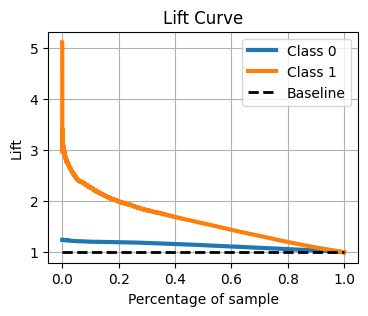

In [41]:
plot_lift_curve(pred_test_df['target'], 
                pd.concat([1-pred_test_df['predict_prob'], pred_test_df['predict_prob']], axis=1), 
                title='Lift Curve', ax=None, figsize=(4,3), 
                title_fontsize='large', text_fontsize='medium')
plt.gca().legend(loc='upper right')
plt.gcf().savefig(Path(setup.temp_path).joinpath('A20_PLOT_lift_curve.png'),bbox_inches='tight')

## Feature Importance 

##### XGBoost gain

In [42]:
feat_impgain = pd.DataFrame(xgb_model.get_booster().get_score(importance_type='gain'),
                                     index=['importance']).T \
    .sort_values('importance', ascending=False)

In [43]:
feat_impgain.to_csv(Path(setup.temp_path).joinpath('A20_REPORT_importance_gain.csv'), index=True)

In [44]:
feat_impgain.head()

,importance
urban_flag,669.639893
LowDoc,127.190926
DisbursementGross,80.710114
tt_NAICS_3,53.658234
tt_NAICS_4,45.902760


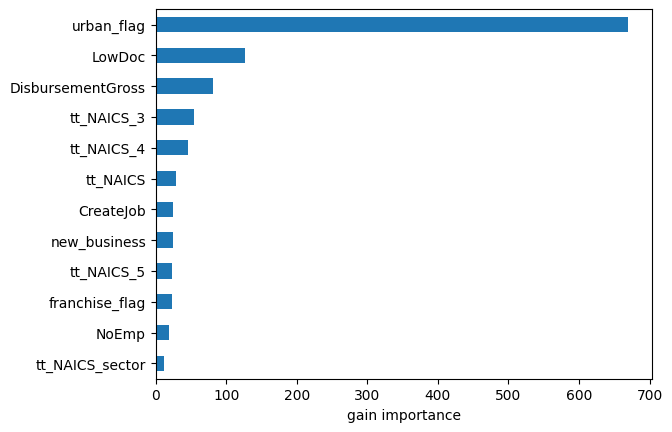

In [45]:
feat_impgain.plot(kind='barh', legend=None)
plt.gca().invert_yaxis()
plt.xlabel('gain importance')
plt.gcf().savefig(Path(setup.temp_path).joinpath('A20_PLOT_importance_gain.png'))

##### Permutation Importance

In [46]:
perm_importance = permutation_importance(xgb_model, 
                                         train_df[predictor_features],  train_df['target'],
                                         n_repeats=30, scoring = 'average_precision')

In [47]:
perm_importance_df = pd.DataFrame({'features':predictor_features,
                                   'importance': perm_importance['importances_mean']}) 
perm_importance_df['abs_importance'] = np.abs(perm_importance_df['importance'])
perm_importance_df = perm_importance_df.sort_values('abs_importance', ascending=False)

In [48]:
perm_importance_df.head(5)

,features,importance,abs_importance
3,DisbursementGross,0.075758,0.075758
5,urban_flag,0.041677,0.041677
1,CreateJob,0.022419,0.022419
10,tt_NAICS_3,0.018901,0.018901
7,tt_NAICS,0.015611,0.015611


In [49]:
perm_importance_df \
    .to_csv(Path(setup.temp_path).joinpath('A20_DATA_importance_perturb.csv'),
            index=False)

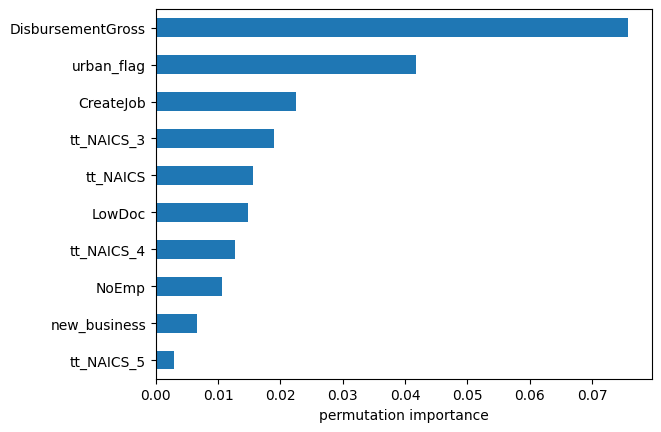

In [50]:
perm_importance_df.head(10).plot(kind='barh', x='features', y='importance', legend=None)
plt.gca().invert_yaxis()
plt.xlabel('permutation importance')
plt.ylabel(None)
plt.gcf().savefig(Path(setup.temp_path).joinpath('A20_PLOT_importance_perturb.png'))

## PDP Plot - encoding features

In [57]:
feat_list = list(enc_val.columns)

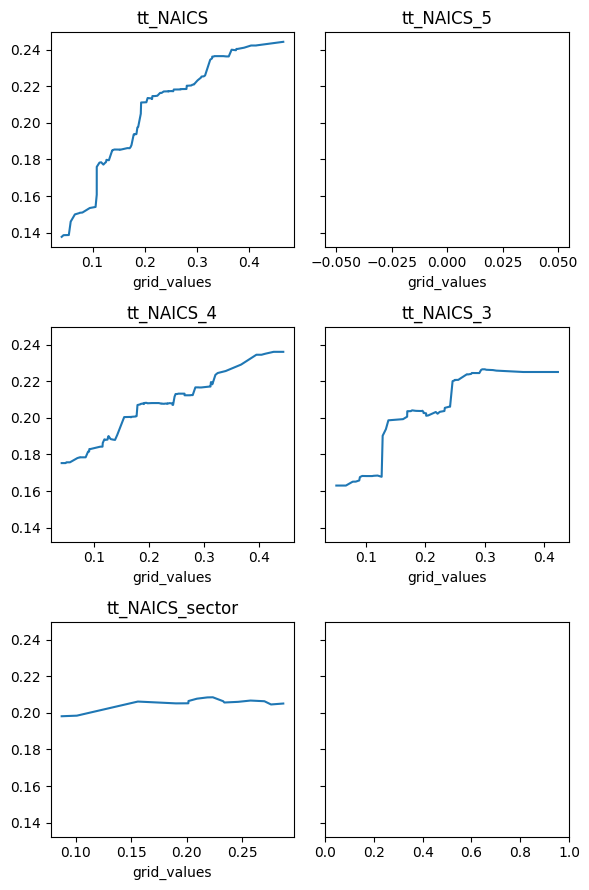

In [60]:
fig, ax = plt.subplots(int(np.ceil(len(feat_list)/2)), 2, sharex=False, 
                       sharey=True, figsize=(6, 9))
for i in range(len(feat_list)):
    col = int(i % 2)
    row = int(np.floor(i / 2))
    results = partial_dependence(xgb_model, train_df[predictor_features], 
                                 [feat_list[i]])
    pdp_df = pd.DataFrame({'grid_values':results["grid_values"][0],
                       'pdp':results["average"][0]})
    pdp_df.plot(x='grid_values', y='pdp', legend=None, ax=ax[row, col])
    ax[row, col].set_title(feat_list[i])

fig.tight_layout()
fig.savefig(Path(setup.temp_path).joinpath('A20_PLOT_pdp_combined.png'),
               bbox_inches='tight')
plt.show()